# CEDA OPeNDAP Cru data regridded to Cordex EUR-11 and seasonal means
We want to make a 10 year seasonal mean analysis of REMO data and compare it to CRU TS v. 4.04 gridded datasets.  We want to access CRU TS data from the [CEDA](https://catalogue.ceda.ac.uk/uuid/89e1e34ec3554dc98594a5732622bce9) database. However, instead of downloading and preprocessing, we want to access the dataset remotely. Browsing through the web interface, we find the opendap url

In [1]:
url = "http://dap.ceda.ac.uk/thredds/dodsC/badc/cru/data/cru_ts/cru_ts_4.03/data/tmp/cru_ts4.03.1901.2018.tmp.dat.nc"

Let's check for access (it will probably not work the first time, you execute this notebook):

In [2]:
from netCDF4 import Dataset

ds = Dataset(url)

We need to get a certificate for data access, we take the example code from [here](https://github.com/cedadev/opendap-python-example/blob/master/remote_nc_reader.py), to create a certificate. Once, the certificate is created on your machine, you can access the data. The certification has to be done only once per machine.

In [3]:
import datetime
import os
from getpass import getpass

from contrail.security.onlineca.client import OnlineCaClient

# Import third-party libraries
from cryptography import x509
from cryptography.hazmat.backends import default_backend

# Credentials defaults
DODS_FILE_CONTENTS = """HTTP.COOKIEJAR=./dods_cookies
HTTP.SSL.CERTIFICATE=./credentials.pem
HTTP.SSL.KEY=./credentials.pem
HTTP.SSL.CAPATH=./ca-trustroots
"""

DODS_FILE_PATH = os.path.expanduser("~/.dodsrc")
CERTS_DIR = os.path.expanduser("~/.certs")

if not os.path.isdir(CERTS_DIR):
    os.makedirs(CERTS_DIR)

TRUSTROOTS_DIR = os.path.join(CERTS_DIR, "ca-trustroots")
CREDENTIALS_FILE_PATH = os.path.join(CERTS_DIR, "credentials.pem")

TRUSTROOTS_SERVICE = "https://slcs.ceda.ac.uk/onlineca/trustroots/"
CERT_SERVICE = "https://slcs.ceda.ac.uk/onlineca/certificate/"


def write_dods_file_contents():
    DODS_FILE_CONTENTS = """
    HTTP.COOKIEJAR=./dods_cookies
    HTTP.SSL.CERTIFICATE={credentials_file_path}
    HTTP.SSL.KEY={credentials_file_path}
    HTTP.SSL.CAPATH={trustroots_dir}
    """.format(
        credentials_file_path=CREDENTIALS_FILE_PATH, trustroots_dir=TRUSTROOTS_DIR
    )

    with open(DODS_FILE_PATH, "w") as dods_file:
        dods_file.write(DODS_FILE_CONTENTS)


def cert_is_valid(cert_file, min_lifetime=0):
    """
    Returns boolean - True if the certificate is in date.
    Optional argument min_lifetime is the number of seconds
    which must remain.
    :param cert_file: certificate file path.
    :param min_lifetime: minimum lifetime (seconds)
    :return: boolean
    """
    try:
        with open(cert_file, "rb") as f:
            crt_data = f.read()
    except OSError:
        return False

    try:
        cert = x509.load_pem_x509_certificate(crt_data, default_backend())
    except ValueError:
        return False

    now = datetime.datetime.now()

    return (
        cert.not_valid_before <= now
        and cert.not_valid_after > now + datetime.timedelta(0, min_lifetime)
    )


def setup_credentials(force=False):
    """
    Download and create required credentials files.
    Return True if credentials were set up.
    Return False is credentials were already set up.
    :param force: boolean
    :return: boolean
    """
    # Test for DODS_FILE and only re-get credentials if it doesn't
    # exist AND `force` is True AND certificate is in-date.
    if (
        os.path.isfile(DODS_FILE_PATH)
        and not force
        and cert_is_valid(CREDENTIALS_FILE_PATH)
    ):
        print("[INFO] Security credentials already set up.")
        return False

    onlineca_client = OnlineCaClient()
    onlineca_client.ca_cert_dir = TRUSTROOTS_DIR

    # Set up trust roots
    trustroots = onlineca_client.get_trustroots(
        TRUSTROOTS_SERVICE, bootstrap=True, write_to_ca_cert_dir=True
    )

    username = input("CEDA username")  # os.environ['CEDA_USERNAME']
    password = getpass("CEDA password")  # os.environ['CEDA_PASSWORD']

    # Write certificate credentials file
    key_pair, certs = onlineca_client.get_certificate(
        username, password, CERT_SERVICE, pem_out_filepath=CREDENTIALS_FILE_PATH
    )

    # Write the dodsrc credentials file
    write_dods_file_contents()

    print("[INFO] Security credentials set up.")
    return True

Now, let's create our credentials.

In [9]:
setup_credentials(force=True)

/work/ch0636/g300046/conda_envs/dask/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'slcs.ceda.ac.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


CEDA username lbuntemeyer
CEDA password ··········


[INFO] Security credentials set up.


True

And now, the access should work:

In [4]:
ds = Dataset(url)
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    Conventions: CF-1.4
    title: CRU TS4.03 Mean Temperature
    institution: Data held at British Atmospheric Data Centre, RAL, UK.
    source: Run ID = 1905011326. Data generated from:tmp.1905011321.dtb
    history: Wed  1 May 2019 15:42:51 BST : User ianharris : Program makegridsauto.for called by update.for
    references: Information on the data is available at http://badc.nerc.ac.uk/data/cru/
    comment: Access to these data is available to any registered CEDA user.
    contact: support@ceda.ac.uk
    DODS_EXTRA.Unlimited_Dimension: time
    dimensions(sizes): time(1416), lat(360), lon(720)
    variables(dimensions): float32 lon(lon), float32 lat(lat), float32 time(time), float32 tmp(time, lat, lon), int32 stn(time, lat, lon)
    groups: 

Ok, cool. We got access! What actually happened is that we only accessed meta data to gather information about the data not the data itself. It's called `lazy` loading (for obvious reasons!).  We prefer xarray datasets to work with in the following steps, so let's open that dataset with xarray:

In [5]:
import xarray as xr

cru_tmp_ds = xr.open_dataset(url)
cru_tmp_ds

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 1416)
Coordinates:
  * lon      (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2018-12-16
Data variables:
    tmp      (time, lat, lon) float32 ...
    stn      (time, lat, lon) float64 ...
Attributes:
    Conventions:                     CF-1.4
    title:                           CRU TS4.03 Mean Temperature
    institution:                     Data held at British Atmospheric Data Ce...
    source:                          Run ID = 1905011326. Data generated from...
    history:                         Wed  1 May 2019 15:42:51 BST : User ianh...
    references:                      Information on the data is available at ...
    comment:                         Access to these data is available to any...
    contact:                         support@ceda.ac.uk
    DODS_EXTRA.Unlimited_Dimension:  time

In [6]:
cru_tmp_ds.tmp

<xarray.DataArray 'tmp' (time: 1416, lat: 360, lon: 720)>
[367027200 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2018-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

Ok, we can see that the Cru dataset covers more than 100 years of gridded observational near surface temperatue data on a monthly resolution. That's something we can work with.

## Loading of ESGF data
ESFG data is either available directly at one of the data nodes, e.g. DKRZ, through the web portal or even opendap access. We will assume, we have access to the data at DKRZ on the filesystem for now. To discover the data, DKRZ provides intake catalogs, e.g.

In [7]:
!ls /work/ik1017/Catalogs/

archive		      mistral-miklip.csv.gz  mistral-MPI-GE.json
mistral-cmip6.csv.gz  mistral-miklip.json    ncar-intake-esm-datastore
mistral-cmip6.json    mistral-MPI-GE.csv.gz  pangeo-cmip6.json


In [8]:
!ls /work/kd0956/Catalogs/

archive		      mistral-cmip5.json~    mistral-era5.csv.gz
mistral-cmip5.csv.gz  mistral-cordex.csv.gz  mistral-era5.json
mistral-cmip5.json    mistral-cordex.json


We will choose the CORDEX data catalog for now, so we use:

In [9]:
cordex_catalog_url = "/work/kd0956/Catalogs/mistral-cordex.json"

We can load an [intake esm](https://github.com/intake/intake-esm) data catalog from this url and immediately start discovering the available cordex datasets.

In [10]:
import intake

cordex_catalog = intake.open_esm_datastore(cordex_catalog_url)

In [11]:
cordex_catalog

,unique
product_id,2
CORDEX_domain,23
institute_id,67
driving_model_id,13
experiment_id,5
member,5
model_id,26
rcm_version_id,5
frequency,7
variable_id,101


The intake catalog is actually build around a pandas dataframe. We can access it also directly:

In [12]:
cordex_catalog.df

,product_id,CORDEX_domain,institute_id,driving_model_id,experiment_id,member,model_id,rcm_version_id,frequency,variable_id,version,time_range,path
0,output,AFR-22,GERICS,MPI-M-MPI-ESM-LR,historical,r1i1p1,GERICS-REMO2015,v1,day,ps,v20191015,19710101-19751231,/mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
1,output,AFR-22,GERICS,MPI-M-MPI-ESM-LR,historical,r1i1p1,GERICS-REMO2015,v1,day,ps,v20191015,19910101-19951231,/mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
2,output,AFR-22,GERICS,MPI-M-MPI-ESM-LR,historical,r1i1p1,GERICS-REMO2015,v1,day,ps,v20191015,19860101-19901231,/mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
3,output,AFR-22,GERICS,MPI-M-MPI-ESM-LR,historical,r1i1p1,GERICS-REMO2015,v1,day,ps,v20191015,19760101-19801231,/mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
4,output,AFR-22,GERICS,MPI-M-MPI-ESM-LR,historical,r1i1p1,GERICS-REMO2015,v1,day,ps,v20191015,20010101-20051231,/mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
955681,output,AUS-22,GERICS,NCC-NorESM1-M,rcp85,r1i1p1,GERICS-REMO2015,v1,1hr,pr,v20191029,209901010100-210001010000,/mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
955682,output,AUS-22,GERICS,NCC-NorESM1-M,rcp85,r1i1p1,GERICS-REMO2015,v1,1hr,pr,v20191029,201501010100-201601010000,/mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
955683,output,AUS-22,GERICS,NCC-NorESM1-M,rcp85,r0i0p0,GERICS-REMO2015,v1,fx,sftlf,v20191029,r0i0p0,/mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
955684,output,AUS-22,GERICS,NCC-NorESM1-M,rcp85,r0i0p0,GERICS-REMO2015,v1,fx,orog,v20191029,r0i0p0,/mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...


The great thing about this is that the catalog abstracts the filename from meta data. That means, we can search and access data using actual model or data attributes instead of having to know where the data actually resides on the filesystem or knowing its filename. This makes our data access independent from the actual details of the data provider and ensures reproducibility. We can now use model attributes to search the catalog as you would do in the ESGF web interface:

In [13]:
attrs = {
    "CORDEX_domain": "EUR-11",
    "variable_id": "tas",
    "experiment_id": "historical",
    "model_id": "GERICS-REMO2015",
    "frequency": "mon",
}

In [14]:
selection = cordex_catalog.search(**attrs)

In [15]:
selection

,unique
product_id,1
CORDEX_domain,1
institute_id,2
driving_model_id,4
experiment_id,1
member,2
model_id,1
rcm_version_id,1
frequency,1
variable_id,1


Ok! You see, we have narrowed our catalog search to the REMO model and found four different driving models.

In [16]:
selection.df.driving_model_id.unique()

array(['MPI-M-MPI-ESM-LR', 'IPSL-IPSL-CM5A-LR', 'NOAA-GFDL-GFDL-ESM2G',
       'NCC-NorESM1-M'], dtype=object)

Let's say, we take those datasets. The catalog provides a column called `path` which points to the actual data filenames on the filesystem:

In [17]:
selection.df.path

0     /mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
1     /mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
2     /mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
3     /mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
4     /mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
5     /mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
6     /mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
7     /mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
8     /mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
9     /mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
10    /mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
11    /mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
12    /mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
13    /mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
14    /mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
15    /mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
16    /mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...
17    /mnt/lustre01/work/kd0956/CORDEX/data/cord

However, instead of sorting these out and opening them by hand, intake already knows about how to logically accumulate single files into a logical dataset, e.g.:

In [18]:
filepath = selection.df.path[0]
filepath

'/mnt/lustre01/work/kd0956/CORDEX/data/cordex/output/EUR-11/GERICS/MPI-M-MPI-ESM-LR/historical/r3i1p1/GERICS-REMO2015/v1/mon/tas/v20190925/tas_EUR-11_MPI-M-MPI-ESM-LR_historical_r3i1p1_GERICS-REMO2015_v1_mon_197101-198012.nc'

In [19]:
!ls /mnt/lustre01/work/kd0956/CORDEX/data/cordex/output/EUR-11/GERICS/MPI-M-MPI-ESM-LR/historical/r3i1p1/GERICS-REMO2015/v1/mon/tas/v20190925

tas_EUR-11_MPI-M-MPI-ESM-LR_historical_r3i1p1_GERICS-REMO2015_v1_mon_195002-195012.nc
tas_EUR-11_MPI-M-MPI-ESM-LR_historical_r3i1p1_GERICS-REMO2015_v1_mon_195101-196012.nc
tas_EUR-11_MPI-M-MPI-ESM-LR_historical_r3i1p1_GERICS-REMO2015_v1_mon_196101-197012.nc
tas_EUR-11_MPI-M-MPI-ESM-LR_historical_r3i1p1_GERICS-REMO2015_v1_mon_197101-198012.nc
tas_EUR-11_MPI-M-MPI-ESM-LR_historical_r3i1p1_GERICS-REMO2015_v1_mon_198101-199012.nc
tas_EUR-11_MPI-M-MPI-ESM-LR_historical_r3i1p1_GERICS-REMO2015_v1_mon_199101-200012.nc
tas_EUR-11_MPI-M-MPI-ESM-LR_historical_r3i1p1_GERICS-REMO2015_v1_mon_200101-200512.nc


intake knows that all these files are part of one dataset describing a timerange from 1950 to 2005. So it's easy to get all datasets that we selected into single datasets like this:

In [74]:
dsets = selection.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'CORDEX_domain.driving_model_id.institute_id.model_id.experiment_id.frequency'


In [84]:
dsets.keys()

dict_keys(['EUR-11.NCC-NorESM1-M.z_GERICS_KB.GERICS-REMO2015.historical.mon', 'EUR-11.MPI-M-MPI-ESM-LR.GERICS.GERICS-REMO2015.historical.mon', 'EUR-11.NOAA-GFDL-GFDL-ESM2G.GERICS.GERICS-REMO2015.historical.mon', 'EUR-11.NCC-NorESM1-M.GERICS.GERICS-REMO2015.historical.mon', 'EUR-11.IPSL-IPSL-CM5A-LR.GERICS.GERICS-REMO2015.historical.mon'])

In [85]:
dsets["EUR-11.MPI-M-MPI-ESM-LR.GERICS.GERICS-REMO2015.historical.mon"]

<xarray.Dataset>
Dimensions:  (member: 1, rlat: 412, rlon: 424, time: 671)
Coordinates:
  * time     (time) datetime64[ns] 1971-01-16T12:00:00 ... 1960-12-16T12:00:00
  * rlat     (rlat) float64 -23.38 -23.27 -23.16 -23.05 ... 21.61 21.72 21.84
  * rlon     (rlon) float64 -28.38 -28.27 -28.16 -28.05 ... 17.93 18.04 18.16
    lat      (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon      (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
    height   float64 ...
  * member   (member) <U6 'r3i1p1'
Data variables:
    tas      (member, time, rlat, rlon) float32 dask.array<chunksize=(1, 120, 412, 424), meta=np.ndarray>
Attributes:
    driving_model_id:               MPI-M-MPI-ESM-LR
    table_id:                       Table mon (Mar 2015) c0a10bad89df35dfced7...
    history:                        There is no special history for this expe...
    realization:                    3
    references:                     http://www.remo-rcm.de
    model_id:                       GERICS-REMO2015
    experiment_id:                  historical
    experiment:                     historical
    comment:                        CORDEX Europe RCM REMO EUR-11. Data_polic...
    contact:                        gerics-cordex@hzg.de
    physics_version:                1
    parent_experiment_id:           N/A
    driving_experiment:             MPI-M-MPI-ESM-LR, historical, r3i1p1
    project_id:                     CORDEX
    branch_time:                    0.0
    title:                          GERICS-REMO2015 model output prepared for...
    intake_esm_varname:             ['tas']
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    parent_experiment:              N/A
    CORDEX_domain:                  EUR-11
    frequency:                      mon
    parent_experiment_rip:          N/A
    institute_id:                   GERICS
    product:                        output
    Conventions:                    CF-1.4
    rcm_version_id:                 v1
    cmor_version:                   2.9.1
    forcing:                        N/A
    tracking_id:                    hdl:21.14103/e4e221f7-e5bc-4eab-bceb-fb78...
    source:                         GERICS-REMO2015
    creation_date:                  2019-06-19T15:44:21Z
    modeling_realm:                 atmos
    initialization_method:          1
    driving_experiment_name:        historical
    driving_model_ensemble_member:  r3i1p1
    intake_esm_dataset_key:         EUR-11.MPI-M-MPI-ESM-LR.GERICS.GERICS-REM...

**HACK: Filenames in the table are not sorted by date, so the files are not concatenated correctly.**

In [20]:
files = list(
    selection.df.groupby("driving_model_id").get_group("MPI-M-MPI-ESM-LR").path
)
files.sort()
files

['/mnt/lustre01/work/kd0956/CORDEX/data/cordex/output/EUR-11/GERICS/MPI-M-MPI-ESM-LR/historical/r3i1p1/GERICS-REMO2015/v1/mon/tas/v20190925/tas_EUR-11_MPI-M-MPI-ESM-LR_historical_r3i1p1_GERICS-REMO2015_v1_mon_195002-195012.nc',
 '/mnt/lustre01/work/kd0956/CORDEX/data/cordex/output/EUR-11/GERICS/MPI-M-MPI-ESM-LR/historical/r3i1p1/GERICS-REMO2015/v1/mon/tas/v20190925/tas_EUR-11_MPI-M-MPI-ESM-LR_historical_r3i1p1_GERICS-REMO2015_v1_mon_195101-196012.nc',
 '/mnt/lustre01/work/kd0956/CORDEX/data/cordex/output/EUR-11/GERICS/MPI-M-MPI-ESM-LR/historical/r3i1p1/GERICS-REMO2015/v1/mon/tas/v20190925/tas_EUR-11_MPI-M-MPI-ESM-LR_historical_r3i1p1_GERICS-REMO2015_v1_mon_196101-197012.nc',
 '/mnt/lustre01/work/kd0956/CORDEX/data/cordex/output/EUR-11/GERICS/MPI-M-MPI-ESM-LR/historical/r3i1p1/GERICS-REMO2015/v1/mon/tas/v20190925/tas_EUR-11_MPI-M-MPI-ESM-LR_historical_r3i1p1_GERICS-REMO2015_v1_mon_197101-198012.nc',
 '/mnt/lustre01/work/kd0956/CORDEX/data/cordex/output/EUR-11/GERICS/MPI-M-MPI-ESM-LR/his

In [21]:
remo_tas_mpi_esm_ds = xr.open_mfdataset(files)

In [22]:
# this wont work because files are not sorted in the catalog by default
# remo_tas_mpi_esm_ds = dsets['EUR-11.NOAA-GFDL-GFDL-ESM2G.GERICS.GERICS-REMO2015.historical.mon']
remo_tas_mpi_esm_ds.time

<xarray.DataArray 'time' (time: 671)>
array(['1950-02-15T00:00:00.000000000', '1950-03-16T12:00:00.000000000',
       '1950-04-16T00:00:00.000000000', ..., '2005-10-16T12:00:00.000000000',
       '2005-11-16T00:00:00.000000000', '2005-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-02-15 ... 2005-12-16T12:00:00
    height   float64 2.0
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [23]:
cru_tas_hist = cru_tmp_ds.sel(time=slice("1990-01-01", "1999-12-31"))
cru_tas_hist

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 120)
Coordinates:
  * lon      (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1990-01-16 1990-02-15 ... 1999-12-16
Data variables:
    tmp      (time, lat, lon) float32 ...
    stn      (time, lat, lon) float64 ...
Attributes:
    Conventions:                     CF-1.4
    title:                           CRU TS4.03 Mean Temperature
    institution:                     Data held at British Atmospheric Data Ce...
    source:                          Run ID = 1905011326. Data generated from...
    history:                         Wed  1 May 2019 15:42:51 BST : User ianh...
    references:                      Information on the data is available at ...
    comment:                         Access to these data is available to any...
    contact:                         support@ceda.ac.uk
    DODS_EXTRA.Unlimited_Dimension:  time

In [24]:
remo_tas_hist = remo_tas_mpi_esm_ds.sel(time=slice("1990-01-01", "1999-12-31"))

In [25]:
cru_tas_hist.tmp[0].plot()

In [26]:
cru_tas_seasmean = cru_tas_hist.groupby("time.season").mean("time")

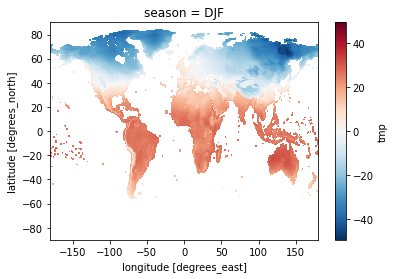

In [27]:
cru_tas_seasmean.tmp.sel(season="DJF").plot()

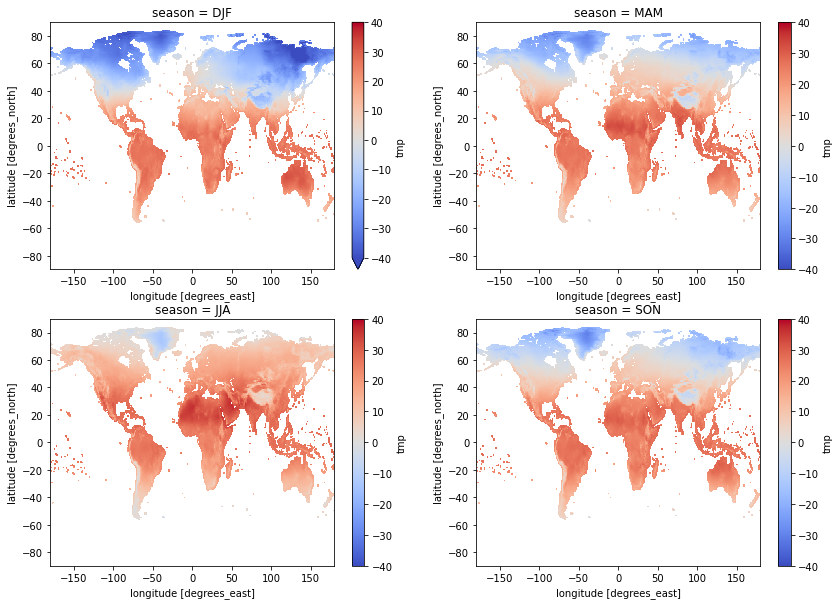

In [32]:
from matplotlib import pyplot as plt


def a_burns_for_all_seasons(da, vmin=-40, vmax=40, cmap="coolwarm"):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(14, 10))
    da.sel(season="DJF").plot(ax=ax1, vmin=vmin, vmax=vmax, cmap=cmap)
    da.sel(season="MAM").plot(ax=ax2, vmin=vmin, vmax=vmax, cmap=cmap)
    da.sel(season="JJA").plot(ax=ax3, vmin=vmin, vmax=vmax, cmap=cmap)
    da.sel(season="SON").plot(ax=ax4, vmin=vmin, vmax=vmax, cmap=cmap)


a_burns_for_all_seasons(cru_tas_seasmean.tmp)

In [33]:
remo_tas_seasmean = remo_tas_hist.groupby("time.season").mean("time")

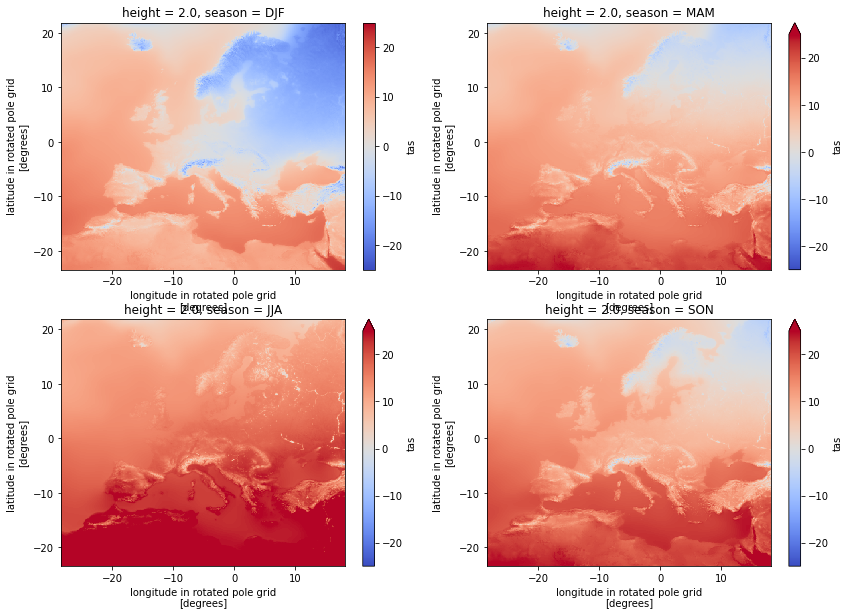

In [36]:
a_burns_for_all_seasons(remo_tas_seasmean.tas - 273.15, vmin=-25, vmax=25)

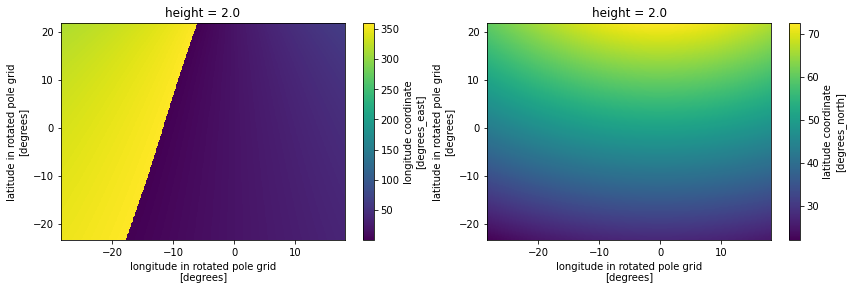

In [37]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))
remo_tas_hist.lon.plot(ax=ax1)
remo_tas_hist.lat.plot(ax=ax2)

In [38]:
pole = remo_tas_hist.rotated_latitude_longitude

In [39]:
import cartopy.crs as ccrs

rotated_pole = ccrs.RotatedPole(
    pole_latitude=pole.grid_north_pole_latitude,
    pole_longitude=pole.grid_north_pole_longitude,
)
rotated_pole

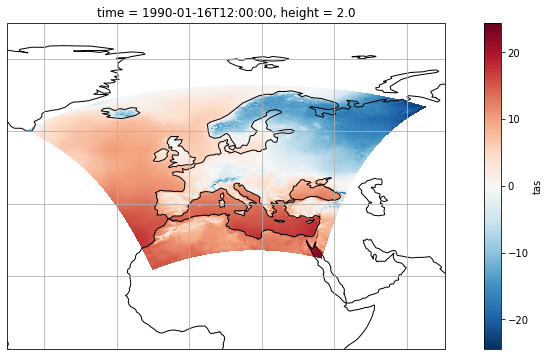

In [40]:
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
(remo_tas_hist.tas[0] - 273.15).plot.pcolormesh(
    ax=ax, transform=rotated_pole, add_colorbar=True
)
ax.coastlines()
ax.gridlines()
ax.set_ylim([0, 90]);

In [41]:
import xesmf as xe

# https://xesmf.readthedocs.io/en/latest/notebooks/Curvilinear_grid.html

In [42]:
regridder = xe.Regridder(cru_tas_hist, remo_tas_hist, "bilinear")

In [43]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_360x720_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (360, 720) 
Output grid shape:          (412, 424) 
Output grid dimension name: ('rlat', 'rlon') 
Periodic in longitude?      False

In [44]:
cru_regrid = regridder(cru_tas_seasmean.tmp)

/work/ch0636/g300046/conda_envs/dask/lib/python3.7/site-packages/xesmf/frontend.py:459: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [45]:
cru_regrid["rlon"] = remo_tas_hist.rlon
cru_regrid["rlat"] = remo_tas_hist.rlat
cru_regrid

<xarray.DataArray 'tmp' (season: 4, rlat: 412, rlon: 424)>
array([[[ 20.1275106 ,  20.08979738,  20.05792279, ...,          nan,
                  nan,          nan],
        [ 20.01227337,  19.98045815,  19.95450105, ...,          nan,
                  nan,          nan],
        [ 19.89017445,  19.86426922,  19.86930898, ...,          nan,
                  nan,          nan],
        ...,
        [ -7.64322118,  -7.66479003,  -7.65189852, ..., -22.94733362,
         -22.66479519, -22.32340442],
        [ -7.52306119,  -7.78479386,  -7.99353144, ..., -23.39140903,
         -23.05366766, -22.71042489],
        [ -7.36395281,  -7.73221673,  -8.36597363, ..., -23.29112824,
         -23.43125844, -23.11341344]],

       [[ 34.4714373 ,  34.48929682,  34.51238169, ...,          nan,
                  nan,          nan],
        [ 34.3715957 ,  34.39476977,  34.42317352, ...,          nan,
                  nan,          nan],
        [ 34.26562887,  34.29411523,  34.346022  , ...,          nan,
                  nan,          nan],
...
        [ -3.50700065,  -3.77472439,  -4.02237222, ...,  -8.29667688,
          -7.89646865,  -7.42810368],
        [ -3.31432569,  -3.89461573,  -4.39250716, ...,  -8.80517185,
          -8.34455856,  -7.87276128],
        [ -3.01440893,  -3.69879565,  -4.72041544, ...,  -8.70473291,
          -8.78197035,  -8.32571952]],

       [[ 28.4280917 ,  28.40738676,  28.393084  , ...,          nan,
                  nan,          nan],
        [ 28.29415067,  28.27992025,  28.27210715, ...,          nan,
                  nan,          nan],
        [ 28.15270098,  28.14495211,  28.17077732, ...,          nan,
                  nan,          nan],
        ...,
        [ -1.05252298,  -1.36461563,  -1.62893816, ...,  -7.24004734,
          -6.89804822,  -6.48961679],
        [ -0.94862025,  -1.60744536,  -2.13004018, ...,  -7.67837563,
          -7.28260796,  -6.87542124],
        [ -0.7413704 ,  -1.4901157 ,  -2.55890556, ...,  -7.55110399,
          -7.66206188,  -7.27561159]]])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
    lon      (rlat, rlon) float32 349.9361 350.03607 ... 64.75965 64.96463
    lat      (rlat, rlon) float32 21.987913 22.027924 ... 66.75225 66.690094
    height   float64 2.0
  * rlon     (rlon) float64 -28.38 -28.27 -28.16 -28.05 ... 17.93 18.04 18.16
  * rlat     (rlat) float64 -23.38 -23.27 -23.16 -23.05 ... 21.61 21.72 21.84
Attributes:
    regrid_method:  bilinear

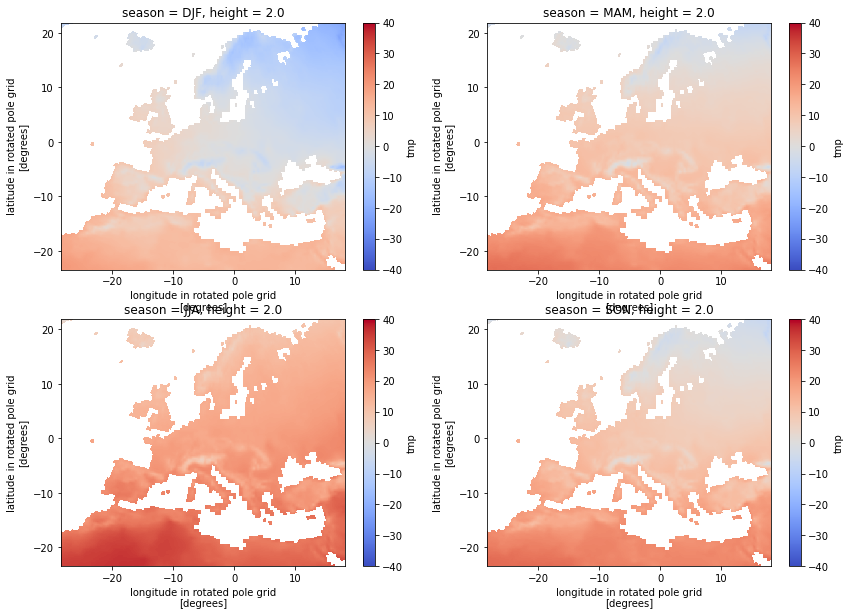

In [46]:
a_burns_for_all_seasons(cru_regrid)

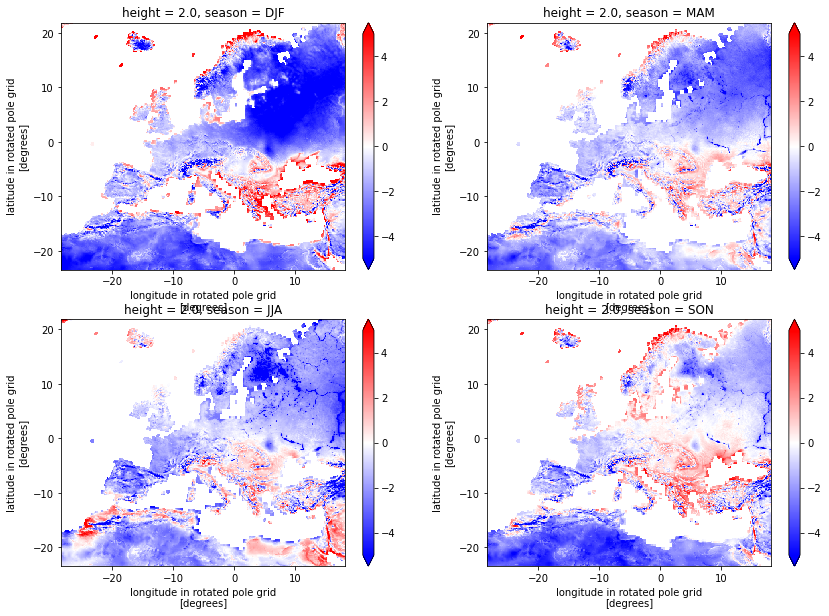

In [48]:
a_burns_for_all_seasons(
    remo_tas_seasmean.tas - cru_regrid - 273.5, vmin=-5, vmax=5, cmap="bwr"
)